# System Info

In [1]:
# Check CUDA info
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


# Load Files

In [2]:
!git clone --quiet https://github.com/AlexeyAB/darknet

In [3]:
%cd darknet

/content/darknet


In [ ]:
# Pretrained weights with COCO dataset
!wget -q https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [8]:
# Pretrained weights with 80 classes
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
!wget -q https://raw.githubusercontent.com/RobotEdh/Yolov-4/master/images/6dogs.jpg -O ./data/6dogs.jpg

In [ ]:
!wget -q https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/videos/test.mp4?raw=true -O ./data/street_cam.mp4

# Build Darknet

In [5]:
# Edit Makerfile to enable GPU & OpenCV & build Darknet
%%shell
sed -i 's/OPENCV=0/OPENCV=1/' Makefile
sed -i 's/GPU=0/GPU=1/' Makefile
sed -i 's/CUDNN=0/CUDNN=1/' Makefile
sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
sed -i 's/LIBSO=0/LIBSO=1/' Makefile
make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Predict - Python

In [57]:
from darknet import *

import cv2
from google.colab.patches import cv2_imshow

# additional for webcam
import numpy as np
from base64 import b64decode, b64encode
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image


# for webcam - live
import io
import PIL

In [58]:
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width, height = network_width(network), network_height(network)

In [59]:
def darknet_helper(img, width, height, thresh=0.5):
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                                interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image, thresh=thresh)
    free_image(darknet_image)
    return detections, width_ratio, height_ratio

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
            bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)

    # get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # get OpenCV format image
    img = js_to_image(data) 
    
    # call our darknet helper on webcam image
    detections, width_ratio, height_ratio = darknet_helper(img, width, height)

    # loop through detections and draw them on webcam image
    for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
        cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
        cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
    # save image
    cv2.imwrite(filename, img)

    return filename

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;
        
        var pendingResolve = null;
        var shutdown = false;
        
        function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
        }
        
        function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
            captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
            result = captureCanvas.toDataURL('image/jpeg', 0.8)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
        }
        
        async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);
        
        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);
            
        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);
        
        const instruction = document.createElement('div');
        instruction.innerHTML = 
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };
        
        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640; //video.videoWidth;
        captureCanvas.height = 480; //video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);
        
        return stream;
        }
        async function stream_frame(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();
        
        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }
                
        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }
        
        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
        });
        shutdown = false;
        
        return {'create': preShow - preCreate, 
                'show': preCapture - preShow, 
                'capture': Date.now() - preCapture,
                'img': result};
        }
        ''')

    display(js)
  
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

## Image

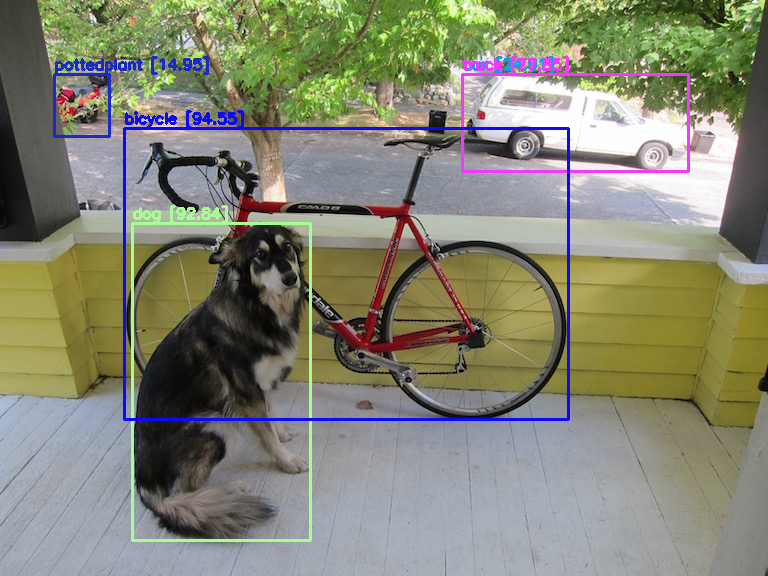

CPU times: user 221 ms, sys: 1.86 ms, total: 223 ms
Wall time: 219 ms


In [38]:
%%time

image = cv2.imread("data/dog.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height, thresh=0.1)    # manipulate `thresh` to filter result

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Webcam - Photo

<IPython.core.display.Javascript object>

Saved to photo.jpg


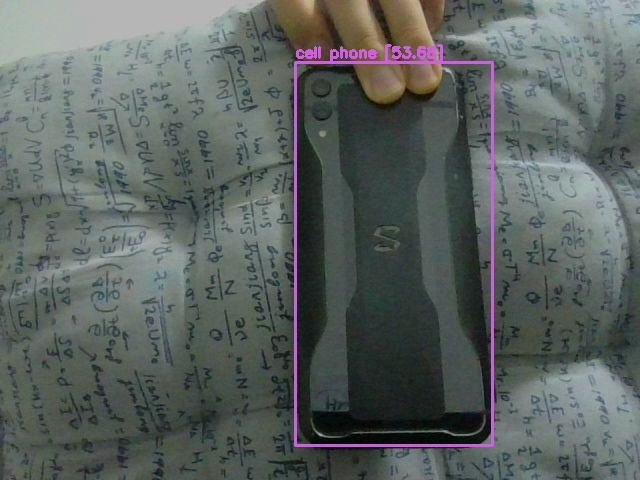

In [46]:
try:
    filename = take_photo('photo.jpg')
    print('Saved to {}'.format(filename))
    display(Image(filename))
except Exception as err:
    print(str(err))

## Webcam - Live

In [63]:
# run this to start webcam & detection
# the detection is delayed by a frame as the overlay is based on last frame

video_stream()  # start streaming video from webcam
label_html = 'Capturing...' # label for video

bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    frame = js_to_image(js_reply["img"])
    
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)  # create transparent overlay for bounding box
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255     
    bbox_bytes = bbox_to_bytes(bbox_array)    
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Functions

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

def download(path):
  from google.colab import files
  files.download(path)

# Prediction - Darknet

## Image

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv   

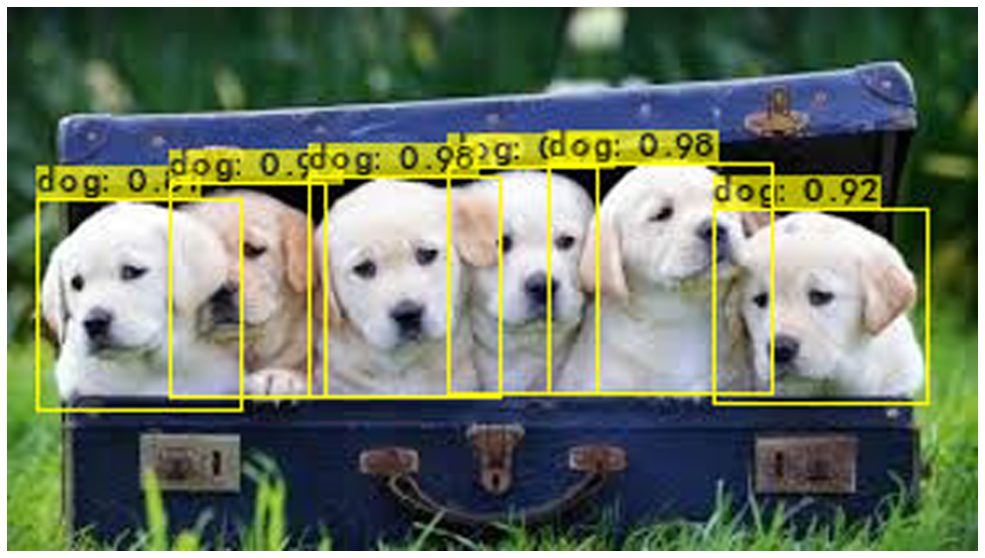

In [ ]:
# !./darknet detector test <path to .data file> <path to config> <path to weights> <path to image>
# -thresh : set threshold for minimum confidence % to pass
# -ext_output : label bouding box
# -dont_show : skip loading output image from darknet to suppress "cannot open display" warning as it's not working on Colab
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/6dogs.jpg -thresh 0.5 -dont_show
imShow('predictions.jpg')

In [ ]:
%%writefile ./data/images.txt
./data/6dogs.jpg
./data/dog.jpg
./data/person.jpg

Overwriting ./data/images.txt


In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -thresh 0.5 -dont_show -out result.json < ./data/images.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv   

In [ ]:
import json
  
with open('./result.json',) as f:
    r = json.load(f)
    for i in r:
        print(i['filename'])
        for o in i['objects']:
            print(o['name'], o['confidence'])
        print()

./data/6dogs.jpg
dog 0.980379
dog 0.97893
dog 0.92584
dog 0.915548
dog 0.89516
dog 0.811475

./data/dog.jpg
dog 0.978775
truck 0.918371
bicycle 0.921853

./data/person.jpg
horse 0.983804
dog 0.9943
person 0.997848



## Video

In [ ]:
!./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show ./data/street_cam.mp4 -i 0 -out_filename pred_street_cam.mp4

# download pred_street_cam.mp4 from `darknet` folder to check result

Streaming output truncated to the last 5000 lines.
person: 93% 
person: 86% 
person: 74% 
person: 72% 
person: 27% 
person: 26% 

FPS:13.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

pottedplant: 33% 
backpack: 36% 
bicycle: 77% 
person: 99% 
person: 99% 
person: 98% 
person: 98% 
person: 97% 
person: 96% 
person: 94% 
person: 86% 
person: 76% 
person: 62% 
person: 30% 
person: 30% 

FPS:14.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

pottedplant: 32% 
backpack: 36% 
bicycle: 75% 
person: 99% 
person: 99% 
person: 98% 
person: 97% 
person: 97% 
person: 96% 
person: 92% 
person: 84% 
person: 77% 
person: 32% 
person: 27% 
person: 26% 

FPS:14.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

pottedplant: 31% 
handbag: 31% 
handbag: 28% 
backpack: 32% 
bicycle: 73% 
person: 99% 
person: 99% 
person: 98% 
person: 98% 
person: 97% 
person: 97% 
person: 95% 
person: 84% 
person: 69% 
person: 44% 
person: 26% 

FPS:15.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

pottedplant: 31% 
handbag: 30% 
handbag: 27% 
b

In [ ]:
# from IPython.display import HTML
# from base64 import b64encode
# mp4 = open('./pred_street_cam.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

# from kora.drive import upload_public
# url = upload_public('./data/street_cam.mp4')
# from IPython.display import HTML
# HTML(f"""<video src={url} width=500 controls/>""")

In [ ]:
!./darknet -help

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Not an option: -help


# Custom OD - Food
- Tutorial for YOLO custom dataset generation : [link](https://www.youtube.com/watch?v=_4A9inxGqRM)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
mkdir ./data/Food
unzip -q ../gdrive/MyDrive/Dataset/Food/train.zip -d ./data/Food/  
unzip -q ../gdrive/MyDrive/Dataset/Food/test.zip -d ./data/Food/  

In [ ]:
# !cp ./cfg/yolov4-custom.cfg ../gdrive/MyDrive/cfg/yolov4-custom-food.cfg

## edit cfg file in GDrive
# Guidelines:
# batch = 64 
# subdivisions = 16 	# if have issue, set to 32

# max_batches = 6000
# steps = 4800, 5400
# filters = 18 in the three convolutional layers
# classes = 1 in the three YOLO layers 

# width = 416
# height = 416 	# Can be any multiple of 32;

# max_batches = (# of classes) * 2000; at least 6000
# steps = (80% of max_batches), (90% of max_batches)
# filters = (# of classes + 5) * 3 

# change one line from random = 1 to random = 0  if into memory issues or long training time.

In [ ]:
!cp ../gdrive/MyDrive/cfg/yolov4-custom-food.cfg ./cfg

In [ ]:
!cp ../gdrive/MyDrive/cfg/generate_test.py ./
!cp ../gdrive/MyDrive/cfg/generate_train.py ./

### source ###
# !wget -q https://raw.githubusercontent.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/master/yolov4/generate_test.py
# !wget -q https://raw.githubusercontent.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/master/yolov4/generate_train.py

# make sure the directory in .py files above is fit to file structure here
# e.g. 
# ...
# os.chdir(os.path.join("data", "Food", "test"))
# ...
#         image_files.append("data/Food/test/" + filename)
# ...

In [ ]:
!python generate_test.py
!python generate_train.py

In [ ]:
%%writefile ./data/Food/obj.names
food

Writing ./data/Food/obj.names


In [ ]:
%%writefile ./data/Food/obj.data
classses = 1
train = data/Food/train.txt
valid = data/Food/test.txt
names = data/Food/obj.names
backup = ../gdrive/MyDrive/Backup/YOLOv4

Writing ./data/Food/obj.data


In [ ]:
# !wget -q https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

paste this in inspect console to avoid idle kick-out by simulating clicks

```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```

In [ ]:
# resolve memory issue or colab crashing by surpressing output
# %%capture --no-display

# !./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map  
# !./darknet detector train data/Food/obj.data cfg/yolov4-custom-food.cfg yolov4.conv.137 -dont_show -map

# to continue from backup checkpoint if crashed
# !sed -i 's/batch=1/batch=64/' ./cfg/yolov4-custom-food.cfg
# !sed -i 's/subdivisions=1/subdivisions=16/' ./cfg/yolov4-custom-food.cfg
!./darknet detector train data/Food/obj.data cfg/yolov4-custom-food.cfg ../gdrive/MyDrive/Backup/YOLOv4/yolov4-custom-food_last.weights -dont_show 
# 2>&1 | tee -a log.txt

# target loss should be <5, ideally <2 or <1
# latest weight will be saved at backup folder every 100 steps (overwritting) and 1000 steps (new file) as *.weights

# approx. 19s / epoch in this case

Streaming output truncated to the last 5000 lines.
 total_bbox = 715580, rewritten_bbox = 0.311635 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.656053), count: 3, class_loss = 0.754217, iou_loss = 1.411618, total_loss = 2.165835 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.682528), count: 25, class_loss = 5.068714, iou_loss = 3.305641, total_loss = 8.374354 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.721026), count: 25, class_loss = 3.058816, iou_loss = 1.202740, total_loss = 4.261556 
 total_bbox = 715633, rewritten_bbox = 0.311612 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.721035), count: 13, class_loss = 2.940982, iou_loss = 26.044487, total_loss = 28.985468 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.709002), count: 31, class_loss = 6.831051, iou_loss = 6.565205, total_loss = 13.396

In [ ]:
# Check performance (mAP)
!./darknet detector map data/Food/obj.data cfg/yolov4-custom-food.cfg ../gdrive/MyDrive/Backup/YOLOv4/yolov4-custom-food_last.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

In [ ]:
# imShow('chart.png') # show custom object detector training history

Run custom object detection

In [ ]:
import random
from glob2 import glob
!sed -i 's/batch=64/batch=1/' cfg/yolov4-custom-food.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' cfg/yolov4-custom-food.cfg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

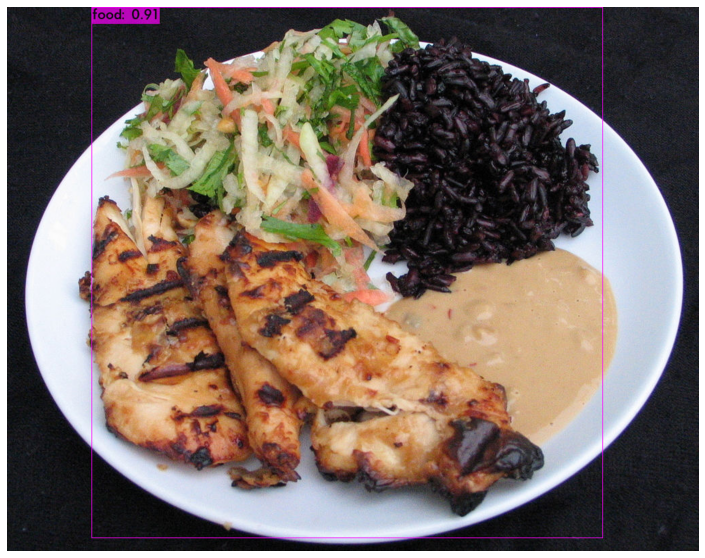

In [ ]:
#  data/Food/test/cd843038ec0aaf64.jpg
!./darknet detector test data/Food/obj.data cfg/yolov4-custom-food.cfg ../gdrive/MyDrive/Backup/YOLOv4/yolov4-custom-food_last.weights data/Food/test/f528365ecebd89f6.jpg -dont_show -thresh 0.3 -out result_1.json
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

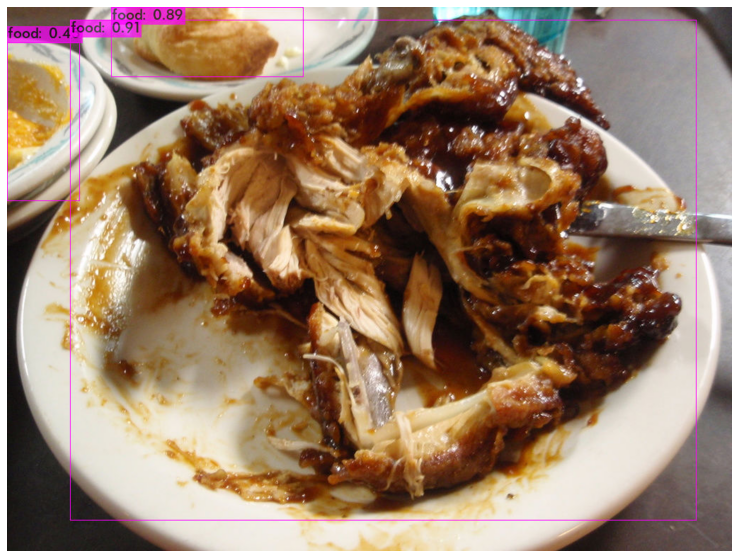

In [ ]:
!./darknet detector test data/Food/obj.data cfg/yolov4-custom-food.cfg ../gdrive/MyDrive/Backup/YOLOv4/yolov4-custom-food_last.weights data/Food/test/4124225b49942fa7.jpg -dont_show -thresh 0.3 -out result_2.json
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

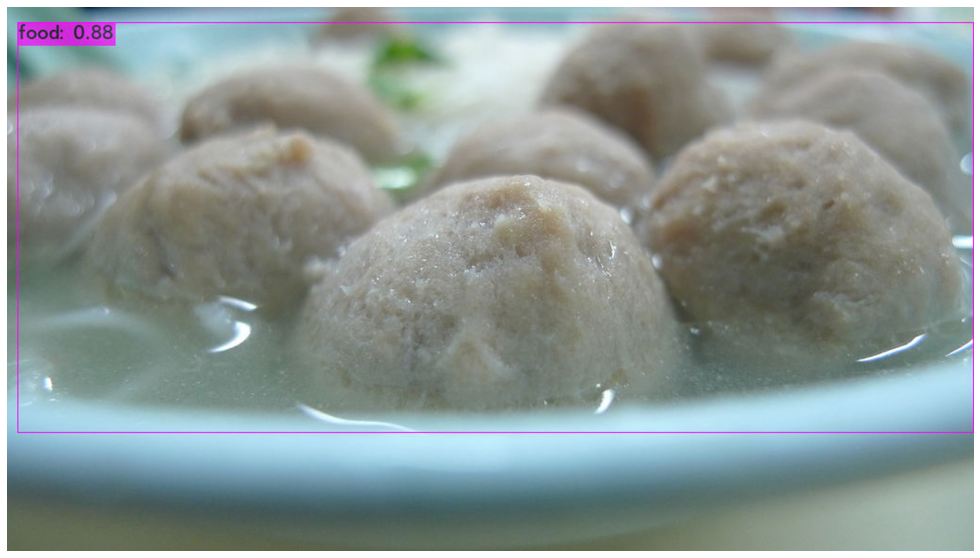

In [ ]:
pic = random.choice(glob('data/Food/test/*.jpg'))
!./darknet detector test data/Food/obj.data cfg/yolov4-custom-food.cfg ../gdrive/MyDrive/Backup/YOLOv4/yolov4-custom-food_last.weights  $pic -dont_show -thresh 0.3 -out result2.json
print("\n\n\n", pic)
imShow('predictions.jpg')